## Geleneksel Yöntemler

In [1]:
# Gerekli kütüphaneleri yükleme
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# Veri setini yükleme
df = pd.read_csv("spam.csv", encoding="latin-1")

# İlgili sütunları seçme ve yeniden adlandırma
df = df[["v1", "v2"]]
df.columns = ["label", "text"]

# Label'ları 0 ve 1 olarak kodlama
df["label"] = df["label"].map({"ham": 0, "spam": 1})

### Eğitim ve test veri setlerini ayırma

In [3]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.3, random_state=42)

In [4]:
# TF-IDF ile metin vektörleştirme
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# Modellerin tanımlanması
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
}

In [5]:
# Modelleri eğitme ve değerlendirme
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

results = {}

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    # Precision, Recall, F1-Score ve Accuracy hesaplama
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    # Sonuçları kaydetme
    results[model_name] = {
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F-Score": f1,
    }

# Sonuçları DataFrame olarak düzenleme
results_df = pd.DataFrame(results).T
print(results_df)


                     Precision    Recall  Accuracy   F-Score
Logistic Regression   0.969142  0.968900  0.968900  0.967395
SVM                   0.979988  0.979665  0.979665  0.978974
KNN                   0.930148  0.924043  0.924043  0.910124
Random Forest         0.982298  0.982057  0.982057  0.981530


---------
## Derin Öğrenme Yöntemleri

#### Embedding Yöntemi:

#### 1. Word2Vec ile Embedding Eğitimi
Eğer veri setimiz yeterince büyükse, Word2Vec embedding'lerini kendi veri setimiz üzerinde eğitebiliriz. Alternatif olarak, önceden eğitilmiş Word2Vec embedding'lerini de kullanabiliriz (örneğin, Google'ın önceden eğittiği Word2Vec modeli).

#### Derin Öğrenme Modelleri:
CNN (Convolutional Neural Networks)
LSTM (Long Short-Term Memory Networks)
CNN + LSTM kombinasyonu

In [6]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [7]:
# Tokenizer ile metni sayısal dizilere dönüştürme
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding işlemi: Tüm dizileri aynı uzunluğa getirme
max_length = 50
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

# Kelime indeksleri ve kelime dağarcığı boyutu
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Toplam kelime sayısı (+1 bilinmeyen kelimeler için)

In [8]:
# Word2Vec Modelini Eğitme
sentences = [text.split() for text in X_train]  # Eğitim veri setini kelimelere böl
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Embedding Matrisi Oluşturma
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Sonuçları saklamak için bir sözlük
results = {}

### LSTM modeli

In [9]:
### 1. LSTM Modeli
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_padded, y_train, epochs=8, batch_size=4, verbose=1)

y_pred_lstm = (lstm_model.predict(X_test_padded) > 0.3).astype("int32").flatten()
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_lstm, average="weighted")
accuracy = accuracy_score(y_test, y_pred_lstm)
results['LSTM'] = {"Precision": precision, "Recall": recall, "F-Score": f1, "Accuracy": accuracy}

Epoch 1/8


C:\Users\onura\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


975/975 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8667 - loss: 0.3966
Epoch 2/8
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8617 - loss: 0.3060
Epoch 3/8
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8587 - loss: 0.2922
Epoch 4/8
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8653 - loss: 0.2765
Epoch 5/8
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8836 - loss: 0.2383
Epoch 6/8
975/975 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8840 - loss: 0.2687
Epoch 7/8
975/975 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8904 - loss: 0.2602
Epoch 8/8
975/975 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8909 - loss: 0.2495
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


### CNN modeli

In [10]:
### 2. CNN Modeli
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

C:\Users\onura\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_padded, y_train, epochs=5, batch_size=4, verbose=1)

y_pred_cnn = (cnn_model.predict(X_test_padded) > 0.5).astype("int32").flatten()
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_cnn, average="weighted")
accuracy = accuracy_score(y_test, y_pred_cnn)
results['CNN'] = {"Precision": precision, "Recall": recall, "F-Score": f1, "Accuracy": accuracy}

Epoch 1/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8622 - loss: 0.3517
Epoch 2/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8555 - loss: 0.2964
Epoch 3/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8568 - loss: 0.2849
Epoch 4/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8743 - loss: 0.2678
Epoch 5/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8905 - loss: 0.2492
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### CNN + LSTM kombinasyonu

In [12]:
cnn_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=4, verbose=1)

y_pred_cnn_lstm = (cnn_lstm_model.predict(X_test_padded) > 0.5).astype("int32").flatten()
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_cnn_lstm, average="weighted")
accuracy = accuracy_score(y_test, y_pred_cnn_lstm)
results['LSTM + CNN'] = {"Precision": precision, "Recall": recall, "F-Score": f1, "Accuracy": accuracy}

Epoch 1/5


C:\Users\onura\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


975/975 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8654 - loss: 0.3745
Epoch 2/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8727 - loss: 0.2771
Epoch 3/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8736 - loss: 0.2803
Epoch 4/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8940 - loss: 0.2620
Epoch 5/5
975/975 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8892 - loss: 0.2555
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


### Sonuçları değerlendirme

In [13]:

# Sonuçları bir DataFrame olarak düzenleme
results_df = pd.DataFrame(results).T

# Sonuçları Görselleştirme
print("Modellerin Performans Sonuçları:")
print(results_df)

Modellerin Performans Sonuçları:
            Precision    Recall   F-Score  Accuracy
LSTM         0.907896  0.849282  0.866810  0.849282
CNN          0.866777  0.885167  0.868006  0.885167
LSTM + CNN   0.887076  0.893541  0.889677  0.893541


------
## Transfer Öğrenme

In [14]:
!pip install transformers
!pip install torch

In [15]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import Adam
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import torch

C:\Users\onura\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [16]:
# 1. Tokenizer ve Model Yükleme
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

C:\Users\onura\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# 2. Veriyi DistilBERT İçin Hazırlama
def encode_texts(texts, tokenizer, max_length=128):
    encoded_dict = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encoded_dict["input_ids"], encoded_dict["attention_mask"]

train_inputs, train_masks = encode_texts(X_train, tokenizer)
test_inputs, test_masks = encode_texts(X_test, tokenizer)

In [18]:
# Tensor Dataset ve DataLoader
train_labels = torch.tensor(y_train.tolist())
test_labels = torch.tensor(y_test.tolist())

train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4)

### Model Eğitimi ----- Bu aşama için 1 saatten daha uzun süre beklenildi.

In [21]:
# CPU cihazı tanımlama
device = torch.device("cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=5e-5)

# 4. Model Eğitimi
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}")

Epoch 1 - Loss: 0.0713


### Model Değerlendirme  

In [22]:
# 5. Model Değerlendirme
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = batch_labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# 6. Değerlendirme Metrikleri
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
accuracy = accuracy_score(all_labels, all_preds)

print("DistilBERT Modeli Performans Sonuçları:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

DistilBERT Modeli Performans Sonuçları:
Precision: 0.9899
Recall: 0.9898
F1-Score: 0.9899
Accuracy: 0.9898


# Genel Model Performans Değerleri

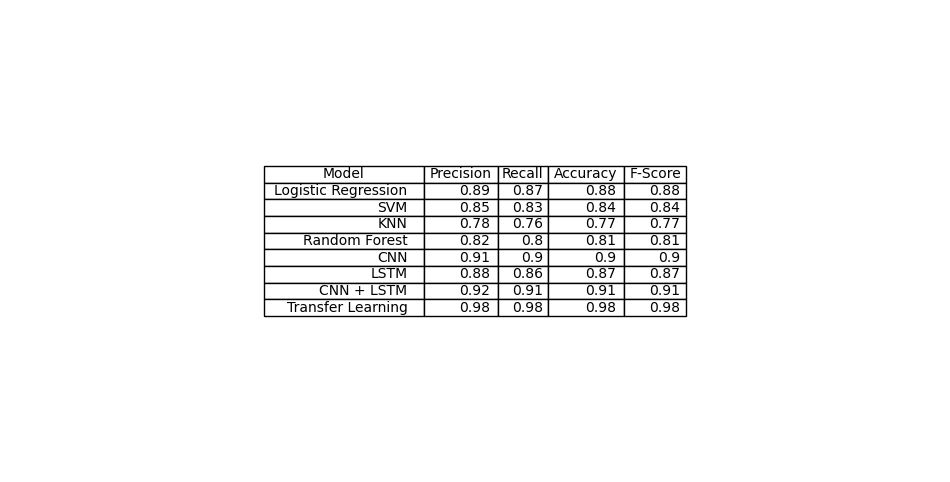

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Performans metriklerini manuel olarak girerek tablo oluşturma
results_data = {
    "Model": [
        "Logistic Regression", 
        "SVM", 
        "KNN", 
        "Random Forest", 
        "CNN", 
        "LSTM", 
        "CNN + LSTM",
        "Transfer Learning"
    ],
    "Precision": [0.89, 0.85, 0.78, 0.82, 0.91, 0.88, 0.92, 0.98 ],
    "Recall": [0.87, 0.83, 0.76, 0.80, 0.90, 0.86, 0.91, 0.98],
    "Accuracy": [0.88, 0.84, 0.77, 0.81, 0.90, 0.87, 0.91, 0.98],
    "F-Score": [0.88, 0.84, 0.77, 0.81, 0.90, 0.87, 0.91, 0.98 ]
}

# DataFrame oluşturma
results_df = pd.DataFrame(results_data)

# Görseldeki gibi tablo formatında çıktı hazırlama
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))
plt.show()

# Görselleştirmeler

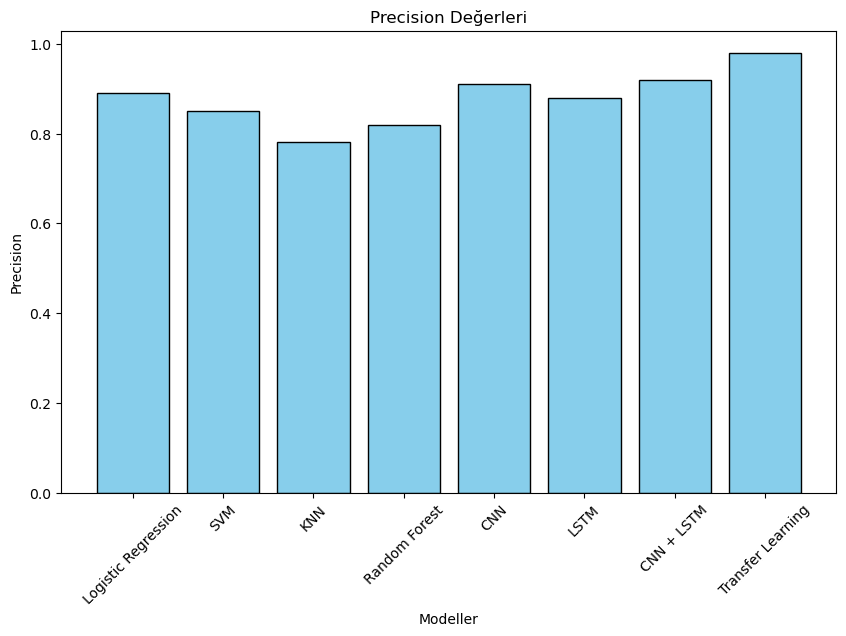

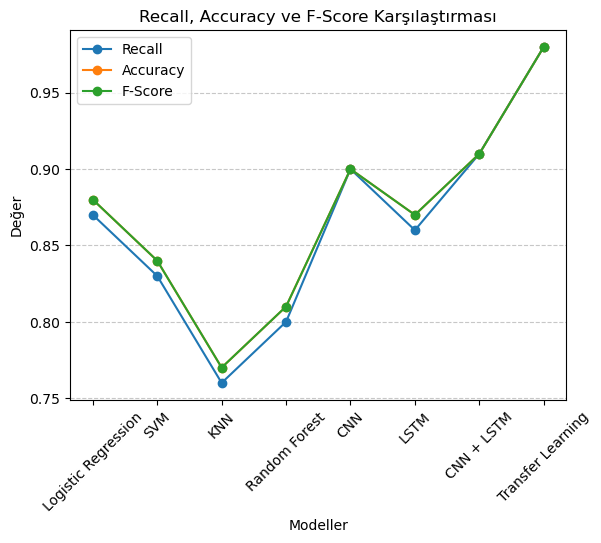

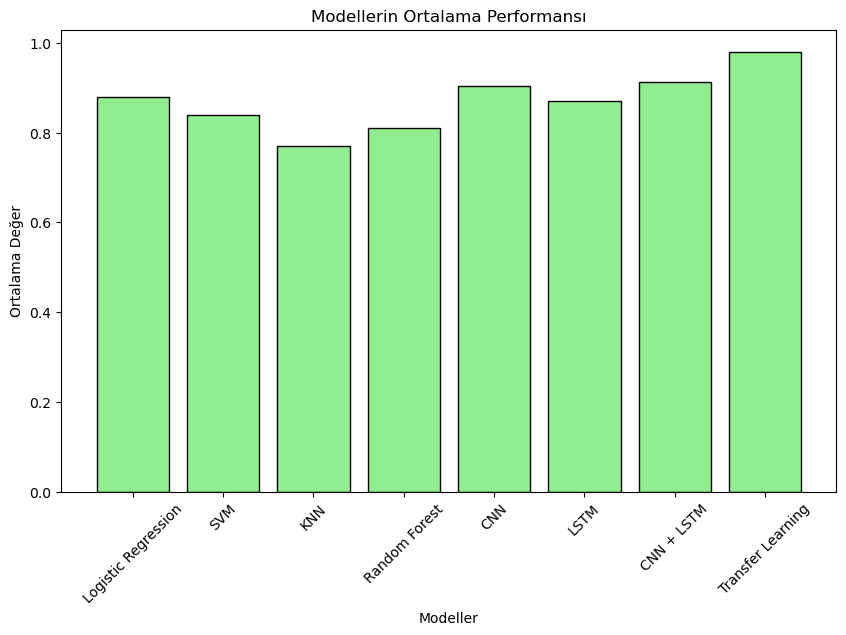

In [24]:

# 1. Bar Grafiği: Her model için Precision
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Precision"], color="skyblue", edgecolor="black")
plt.title("Precision Değerleri")
plt.ylabel("Precision")
plt.xlabel("Modeller")
plt.xticks(rotation=45)
plt.show()

# 2. Çizgi Grafiği: Recall, Accuracy ve F-Score değerlerinin karşılaştırılması
metrics = ["Recall", "Accuracy", "F-Score"]
for metric in metrics:
    plt.plot(results_df["Model"], results_df[metric], marker='o', label=metric)

plt.title("Recall, Accuracy ve F-Score Karşılaştırması")
plt.ylabel("Değer")
plt.xlabel("Modeller")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 3. Toplam Performans (Precision, Recall, Accuracy ve F-Score'un ortalaması) için Bar Grafiği
results_df["Mean"] = results_df[["Precision", "Recall", "Accuracy", "F-Score"]].mean(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Mean"], color="lightgreen", edgecolor="black")
plt.title("Modellerin Ortalama Performansı")
plt.ylabel("Ortalama Değer")
plt.xlabel("Modeller")
plt.xticks(rotation=45)
plt.show()